In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from collections import deque
import random
import cv2

torch.set_float32_matmul_precision('high')
torch._dynamo.config.suppress_errors = True

In [19]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [20]:
initial_state = env.reset()
print(initial_state[0].shape)
state_space_dim = initial_state[0].shape[0]
action_space_dim = 2

(4,)


In [21]:
s, r, done, info, _ = env.step(1)

/home/arnabdey/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [22]:
class Q_Network(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Q_Network, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.input_dim, out_features=32),
            nn.GELU(),
            nn.Linear(in_features=32, out_features=64),
            nn.GELU(),
            nn.Linear(in_features=64, out_features=64),
            nn.GELU(),
            nn.Linear(in_features=64, out_features=self.output_dim)
        )
    def forward(self, x):
        return self.fc(x)

In [23]:
model = Q_Network(input_dim=4, output_dim=2)
model = torch.compile(model).to('cuda')

optimiser = optim.AdamW(params=model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

replay_buffer = deque(maxlen=100000)

In [24]:
num_episodes = 1000
epsilon = 1.0
gamma = 0.95
batch_size = 1024

In [25]:
Losses = []
Cumulative_Rewards = []

for episode in tqdm(range(num_episodes)):
    episode_loss = 0.0
    episode_reward = 0.0
    s = torch.tensor(env.reset()[0], dtype=torch.float32, device='cuda')
    
    done = False
    while not done:
        prob = torch.rand((1,)).item()
        if prob < epsilon:
            a = env.action_space.sample()
        else:
            with torch.no_grad():
                output = model(s.unsqueeze(0))
                a = torch.argmax(output).item()
        
        s_next, reward, done, info, _ = env.step(a)
        episode_reward += reward
        s_next = torch.tensor(s_next, dtype=torch.float32, device='cuda')
        reward = torch.tensor(reward, dtype=torch.float32, device='cuda')
        experience = (s.cpu(), a, reward.cpu(), s_next.cpu(), done)
        replay_buffer.append(experience)

        if done:
            y = reward
        else:
            with torch.no_grad():
                value = torch.max(model(s_next.unsqueeze(0)))
                y = reward + gamma * value
        
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.stack(states).to('cuda')
            actions = torch.tensor(actions, dtype=torch.long, device='cuda')
            rewards = torch.stack(rewards).to('cuda')
            next_states = torch.stack(next_states).to('cuda')
            dones = torch.tensor(dones, dtype=torch.float32, device='cuda')

            current_Q_vals = model(states).gather(1, actions.view(-1,1)).squeeze()
            with torch.no_grad():
                next_Q_vals = model(next_states).max(1)[0]
                target_Q_vals = rewards + gamma * next_Q_vals * (1 - dones)
            loss = criterion(current_Q_vals, target_Q_vals)
            episode_loss += loss.item()
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        s = s_next
        episode_reward += reward.item()
        
    Losses.append(episode_loss)
    Cumulative_Rewards.append(episode_reward)
    epsilon = max(0.01, epsilon * 0.995)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [46:54<00:00,  2.81s/it] 


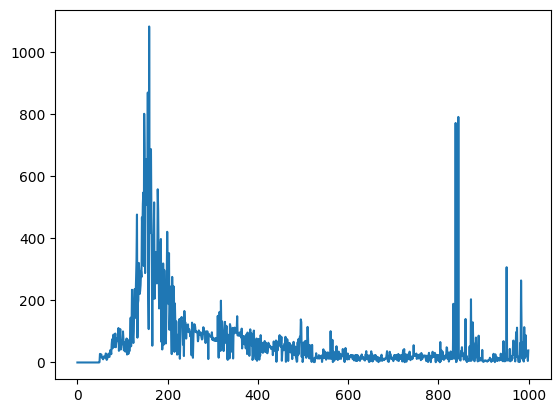

In [26]:
plt.plot(Losses)
plt.show()

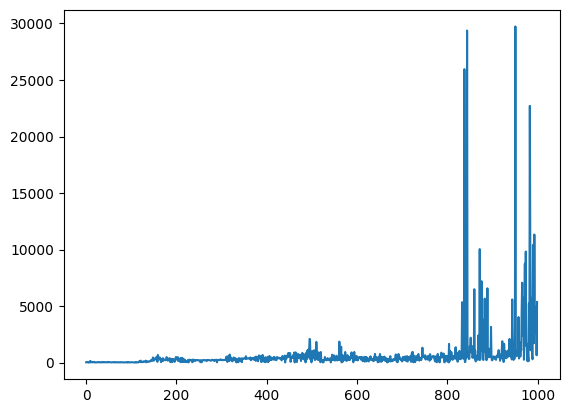

In [27]:
plt.plot(Cumulative_Rewards)
plt.show()

# Testing

In [ ]:
s = torch.tensor(env.reset()[0], dtype=torch.float32, device='cuda')
done = False
Images_List = [env.render()]
while not done:
    with torch.no_grad():
        a = torch.argmax(model(s.squeeze(0))).item()
        s, reward, done, info, _ = env.step(a)
        Images_List.append(env.render())
        s = torch.tensor(s, dtype=torch.float32, device='cuda')

In [29]:
print(len(Images_List))

22532


In [31]:
def save_video_from_images(image_list, output_path, fps=30):
    if not image_list:
        raise ValueError("The image list is empty.")

    height, width, channels = image_list[0].shape
    if channels not in [1, 3]:
        raise ValueError("Images should have 1 or 3 channels (grayscale or RGB).")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for img in image_list:
        if img.dtype != np.uint8:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)

        if len(img.shape) == 2 or img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        video_writer.write(img)

    video_writer.release()
    print(f"Video saved at {output_path}")


In [32]:
output_path = "/home/arnabdey/Placement_ML_projects/RL/play.mp4"
save_video_from_images(Images_List, output_path, fps=30)

Video saved at /home/arnabdey/Placement_ML_projects/RL/play.mp4


In [30]:
torch.save(model.state_dict(), "/home/arnabdey/Placement_ML_projects/RL/CartPole_model.pth")